<p> Для анализа и визуализации данных использовался deepseek. Запросы были формата: </p>
<p> "I have a pandas dataframe df with datetime in column 'date_column'. </p>
<p> I need to make a bar plot that shows distribution of rows within a day(24 hours) to see at what time of a day more rows are created" </p>
<p> Полученный код вставляется и правится. К самим данным и их назначению доступ никому не даётся. </p>

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('kicksharing.csv')

Дубликатов нет

In [35]:
print(df.duplicated().sum())

0


Есть пропуски в личных данных клиентов и кэшбэках. Критических пропусков нет

In [36]:
print(df.isnull().sum())

order_rk                        0
party_rk                        0
gender_cd                    2921
age                             0
education_level_cd         206690
marital_status_cd          179020
lvn_state_nm                34177
minute_cost                     0
activation_cost                 0
hold_amount                     0
transport_model                 0
distance_km                     0
created_dttm                    0
book_start_dttm                 0
book_end_dttm                   0
book_time_zone_cd               0
local_book_start_dttm           0
nominal_price_rub_amt           0
loyalty_accrual_rub_amt     29757
loyalty_accrual_bns_amt    374801
dtype: int64


In [37]:
df['created_dttm'] = pd.to_datetime(df['created_dttm'], format='%Y-%m-%d %H:%M:%S.%f')
df['book_start_dttm'] = pd.to_datetime(df['book_start_dttm'], format='%Y-%m-%d %H:%M:%S.%f')
df['book_end_dttm'] = pd.to_datetime(df['book_end_dttm'], format='%Y-%m-%d %H:%M:%S.%f')

df['avg_speed'] = df['distance_km'] / ((df['book_end_dttm'] - df['book_start_dttm']).dt.total_seconds() / 3600)
df['duration_min'] = (df['book_end_dttm'] - df['book_start_dttm']).dt.total_seconds() / 60

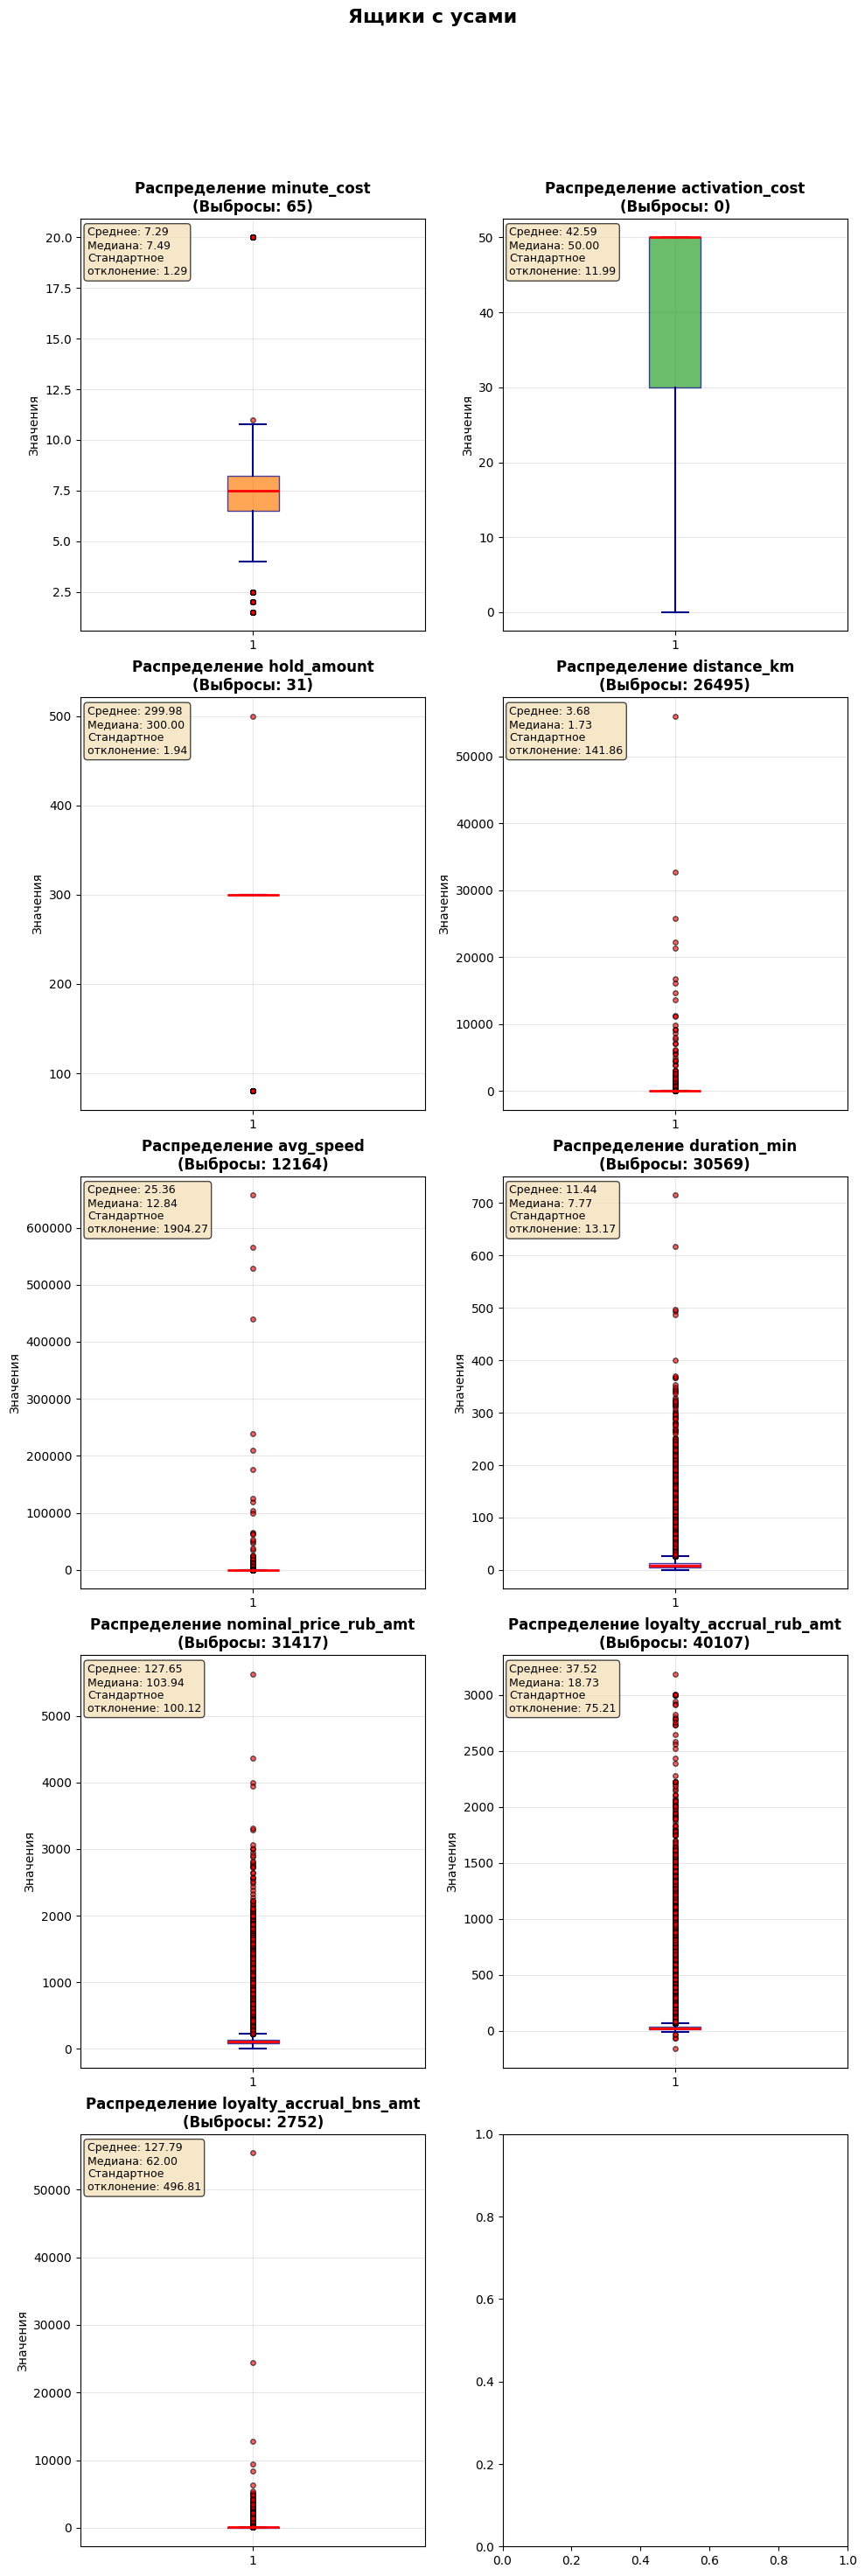

In [38]:
columns_to_plot = ['minute_cost', 'activation_cost', 'hold_amount', 'distance_km', 'avg_speed', 'duration_min', 'nominal_price_rub_amt', 'loyalty_accrual_rub_amt', 'loyalty_accrual_bns_amt']

n_cols = len(columns_to_plot)
n_rows = (n_cols + 1) // 2 

fig, axes = plt.subplots(n_rows, 2, figsize=(10, 30))

axes = axes.flatten()

colors = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

for i, col in enumerate(columns_to_plot):
    if i < len(axes):
        
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        
        
        box_plot = axes[i].boxplot(df[col].dropna(), 
                                    patch_artist=True,
                                    boxprops=dict(facecolor=colors[i], alpha=0.7, edgecolor='darkblue'),
                                    whiskerprops=dict(color='darkblue', linewidth=1.5),
                                    capprops=dict(color='darkblue', linewidth=1.5),
                                    medianprops=dict(color='red', linewidth=2),
                                    flierprops=dict(marker='o', markerfacecolor='red', 
                                                markersize=4, alpha=0.6))
        
        axes[i].set_title(f'Распределение {col}\n(Выбросы: {len(outliers)})', 
                            fontweight='bold', fontsize=12)
        axes[i].set_ylabel('Значения', fontsize=10)
        axes[i].grid(alpha=0.3)
        
        
        stats = df[col].describe()
        text_str = f'Среднее: {stats["mean"]:.2f}\nМедиана: {stats["50%"]:.2f}\nСтандартное\nотклонение: {stats["std"]:.2f}'
        axes[i].text(0.02, 0.98, text_str, transform=axes[i].transAxes, 
                    verticalalignment='top', fontsize=9,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
        
plt.suptitle('Ящики с усами', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.9) 
plt.show()

7 строк с отрицательными кэшбэками в рублях. Это выглядит странно

In [39]:
print(df[df['loyalty_accrual_rub_amt'] < 0][['order_rk', 'party_rk', 'distance_km', 'avg_speed', 'created_dttm', 'loyalty_accrual_rub_amt', 'loyalty_accrual_bns_amt']])

         order_rk    party_rk  distance_km  avg_speed        created_dttm  \
133193  346866316   520065368     2.962408   1.990479 2024-09-17 19:21:36   
218430  350556979  1068354351     0.287968   0.431441 2024-09-30 13:18:30   
225743  263337728   544337483    13.229882  29.624900 2024-07-28 15:43:29   
272310  348557969   904357431     3.125962   3.581261 2024-09-23 15:15:20   
297741  266324787   952764064    29.264670   8.614215 2024-08-08 13:28:06   
299220  351047641   759332373     0.467784   7.238945 2024-10-01 22:19:00   
340555  261319091   943073656    12.620194   3.515234 2024-07-20 13:36:12   

        loyalty_accrual_rub_amt  loyalty_accrual_bns_amt  
133193                   -33.52                      NaN  
218430                   -67.83                      NaN  
225743                    -8.08                      NaN  
272310                   -65.29                      NaN  
297741                   -30.62                      NaN  
299220                    -5.

Счётчик дистанции явно порой выдаёт странные значения. В выбросах это бросается в глаза, но проблема может встречаться чаще чем кажется.

In [40]:
print('Поездок со средней скоростью больше 100 км\ч: ', len(df[df['avg_speed'] > 100]), ' или ', f'{len(df[df["avg_speed"] > 100]) / len(df) * 100:.2f}', '%', sep='')
print('Максимальная скорость в км\ч:', max(df['avg_speed']))

Поездок со средней скоростью больше 100 км\ч: 895 или 0.23%
Максимальная скорость в км\ч: 656965.9119026124


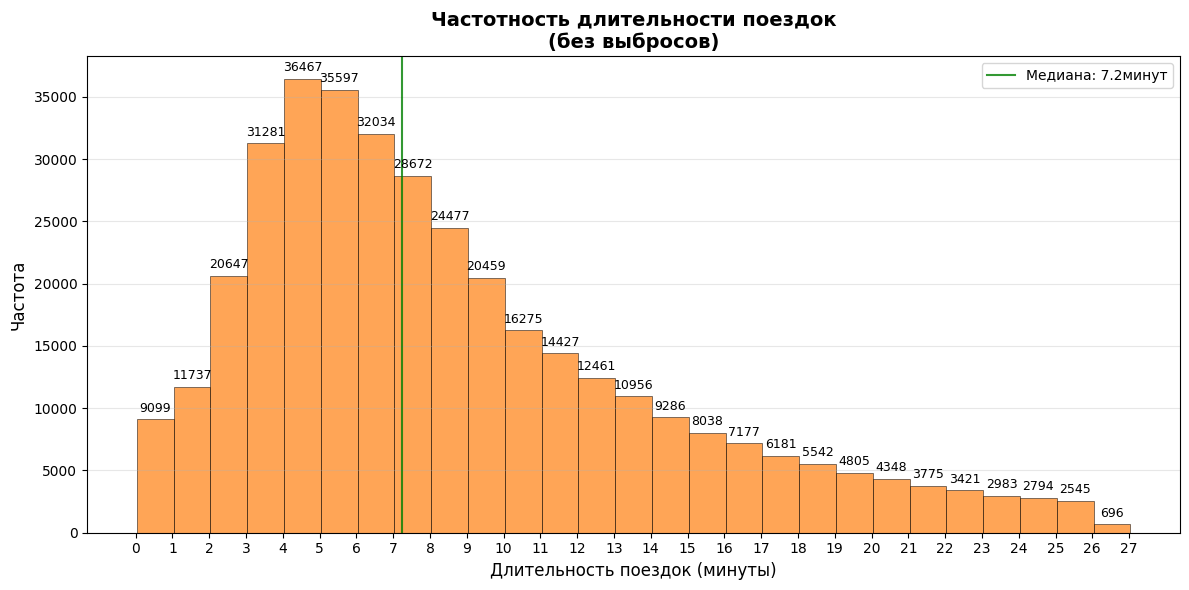

In [41]:
Q1 = df['duration_min'].quantile(0.25)
Q3 = df['duration_min'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = df[(df['duration_min'] >= lower_bound) & (df['duration_min'] <= upper_bound)]['duration_min']

plt.figure(figsize=(12, 6))

bin_width = 1 
bins = np.arange(filtered_data.min(), filtered_data.max() + bin_width, bin_width)

n, bins, patches = plt.hist(filtered_data, bins=bins, alpha=0.7, color='C1', 
                            edgecolor='black', linewidth=0.5)
x_ticks = np.arange(np.floor(filtered_data.min() * 5) / 5, np.ceil(filtered_data.max() * 5) / 5 + bin_width, bin_width)
plt.xticks(x_ticks)
plt.xlabel('Длительность поездок (минуты)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.title('Частотность длительности поездок\n(без выбросов)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

for i, (count, patch) in enumerate(zip(n, patches)):
    plt.text(patch.get_x() + patch.get_width()/2, count + max(n)*0.01,
            f'{int(count)}', ha='center', va='bottom', fontsize=9)

median = filtered_data.median()
plt.axvline(median, color='green', linestyle='-', alpha=0.8, label=f'Медиана: {median:.1f}минут')
plt.legend()
plt.tight_layout()
plt.show()

Большая чать поездок занимает меньше получаса.

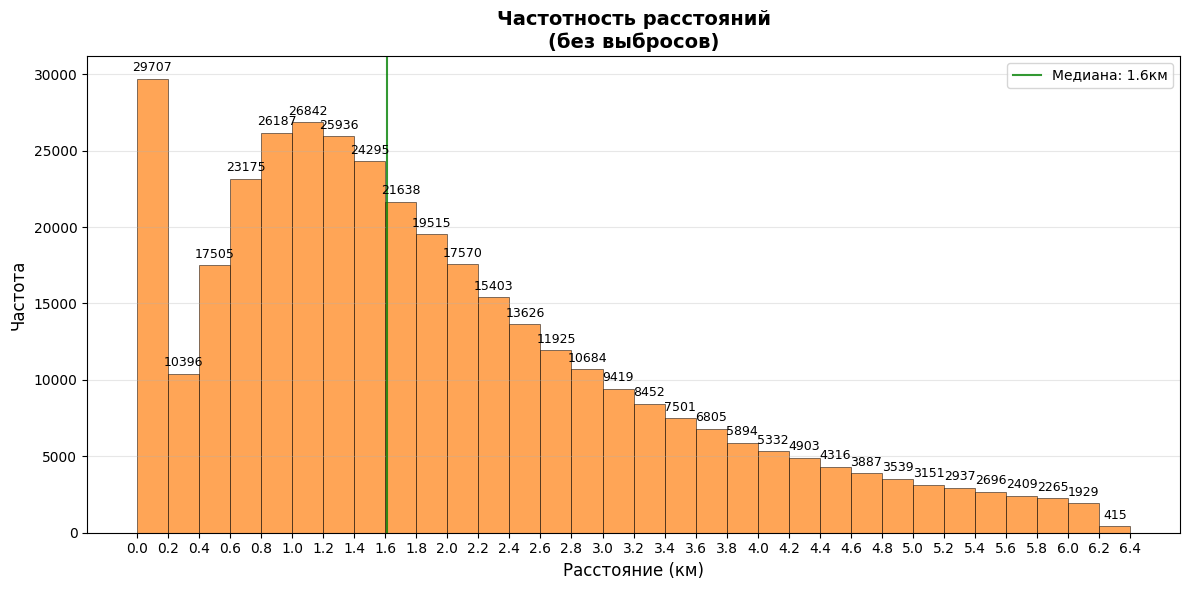

In [42]:
Q1 = df['distance_km'].quantile(0.25)
Q3 = df['distance_km'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = df[(df['distance_km'] >= lower_bound) & (df['distance_km'] <= upper_bound)]['distance_km']

plt.figure(figsize=(12, 6))

bin_width = 0.2 
bins = np.arange(filtered_data.min(), filtered_data.max() + bin_width, bin_width)

n, bins, patches = plt.hist(filtered_data, bins=bins, alpha=0.7, color='C1', 
                            edgecolor='black', linewidth=0.5)
x_ticks = np.arange(np.floor(filtered_data.min() * 5) / 5, np.ceil(filtered_data.max() * 5) / 5 + bin_width, bin_width)
plt.xticks(x_ticks)
plt.xlabel('Расстояние (км)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.title('Частотность расстояний\n(без выбросов)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

for i, (count, patch) in enumerate(zip(n, patches)):
    plt.text(patch.get_x() + patch.get_width()/2, count + max(n)*0.01,
            f'{int(count)}', ha='center', va='bottom', fontsize=9)

median = filtered_data.median()
plt.axvline(median, color='green', linestyle='-', alpha=0.8, label=f'Медиана: {median:.1f}км')
plt.legend()
plt.tight_layout()
plt.show()

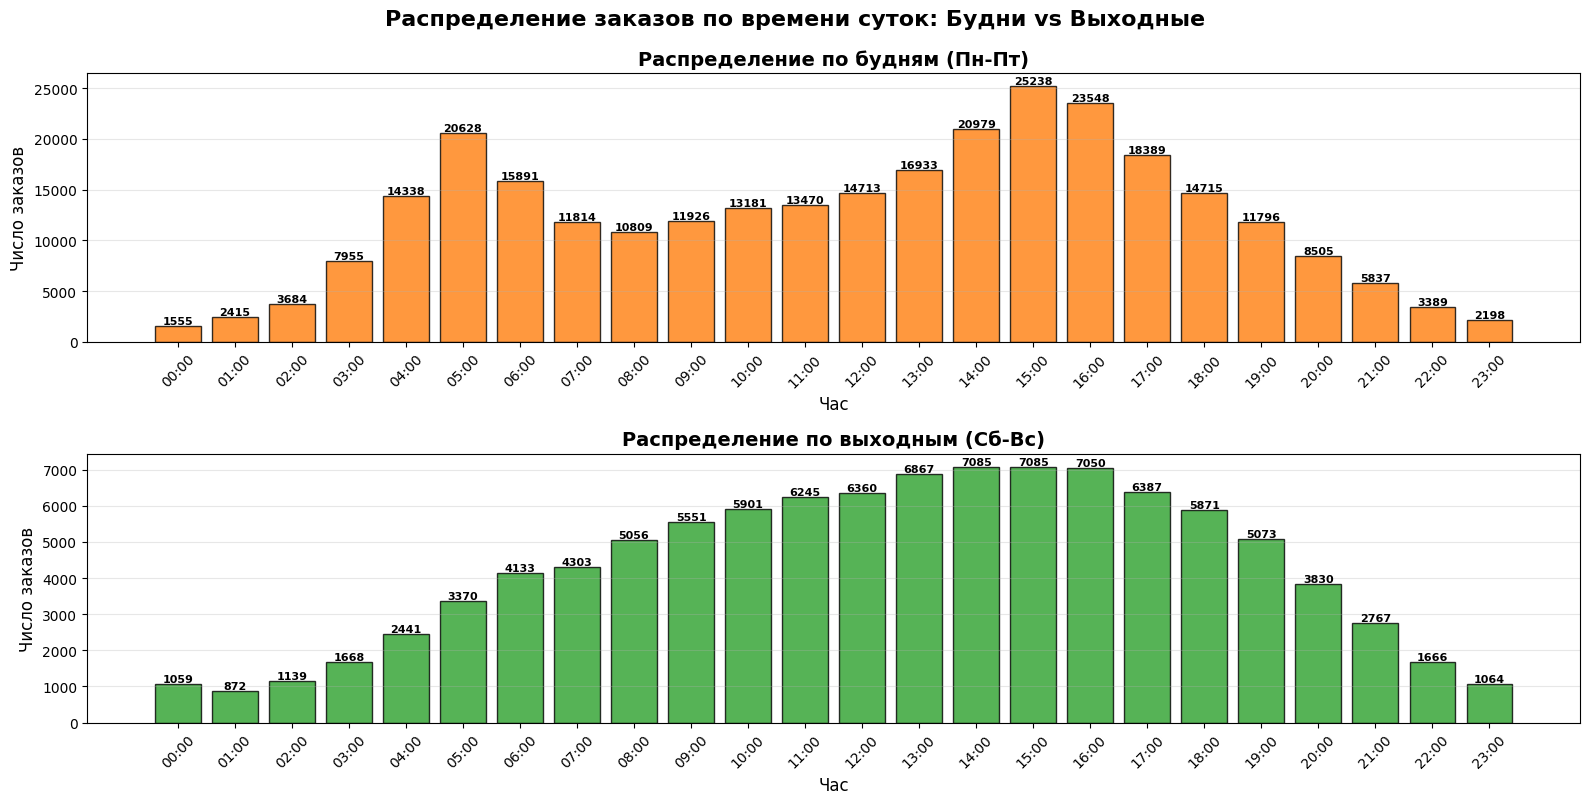

In [43]:
df['hour'] = df['created_dttm'].dt.hour
df['day_of_week'] = df['created_dttm'].dt.dayofweek
df['day_type'] = df['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

weekday_data = df[df['day_type'] == 'Weekday']
weekend_data = df[df['day_type'] == 'Weekend']

weekday_counts = weekday_data['hour'].value_counts().sort_index()
weekend_counts = weekend_data['hour'].value_counts().sort_index()


all_hours = pd.Series(range(24))
weekday_counts = weekday_counts.reindex(all_hours, fill_value=0).sort_index()
weekend_counts = weekend_counts.reindex(all_hours, fill_value=0).sort_index()


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))

bars1 = ax1.bar(weekday_counts.index, weekday_counts.values, color='C1', edgecolor='black', alpha=0.8)

ax1.set_xlabel('Час', fontsize=12)
ax1.set_ylabel('Число заказов', fontsize=12)
ax1.set_title('Распределение по будням (Пн-Пт)', fontsize=14, fontweight='bold')
ax1.set_xticks(range(0, 24))
ax1.set_xticklabels([f'{h:02d}:00' for h in range(24)], rotation=45)
ax1.grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', 
                fontsize=8, fontweight='bold')

bars2 = ax2.bar(weekend_counts.index, weekend_counts.values, color='C2', edgecolor='black', alpha=0.8)

ax2.set_xlabel('Час', fontsize=12)
ax2.set_ylabel('Число заказов', fontsize=12)
ax2.set_title('Распределение по выходным (Сб-Вс)', fontsize=14, fontweight='bold')
ax2.set_xticks(range(0, 24))
ax2.set_xticklabels([f'{h:02d}:00' for h in range(24)], rotation=45)
ax2.grid(axis='y', alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    if height > 0:
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', 
                fontsize=8, fontweight='bold')

plt.suptitle('Распределение заказов по времени суток: Будни vs Выходные', fontsize=16, fontweight='bold', y=1)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [44]:
client_info = df.groupby('party_rk').size().reset_index(name='order_count')

columns_to_include = {
    'gender_cd': 'mode',
    'age': 'latest',
    'education_level_cd': 'mode',
    'marital_status_cd': 'mode',
    'lvn_state_nm': 'mode',
}

for col, method in columns_to_include.items():
    if col in df.columns:
        if method == 'mode':
            col_data = df.groupby('party_rk')[col].apply(
                lambda x: x.dropna().mode().iloc[0] if not x.dropna().empty else 'Missing'
            ).reset_index(name=col)
        elif method == 'latest':
            col_data = df.groupby('party_rk')[col].apply(
                lambda x: x.dropna().iloc[-1] if not x.dropna().empty else np.nan
            ).reset_index(name=col)
        
        client_info = client_info.merge(col_data, on='party_rk', how='left')

client_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64052 entries, 0 to 64051
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   party_rk            64052 non-null  int64 
 1   order_count         64052 non-null  int64 
 2   gender_cd           64052 non-null  object
 3   age                 64052 non-null  int64 
 4   education_level_cd  64052 non-null  object
 5   marital_status_cd   64052 non-null  object
 6   lvn_state_nm        64052 non-null  object
dtypes: int64(3), object(4)
memory usage: 3.4+ MB


In [45]:
client_gender = client_info['gender_cd'].copy()
client_gender.fillna('Missing', inplace=True)
client_gender = client_gender.value_counts()

order_gender = df['gender_cd'].copy()
order_gender.fillna('Missing', inplace=True)
order_gender = order_gender.value_counts()

print('Пол клиентов', client_gender, 'Пол клиентов по заказам', order_gender, sep='\n')

Пол клиентов
gender_cd
M          51399
F          12163
Missing      490
Name: count, dtype: int64
Пол клиентов по заказам
gender_cd
M          335458
F           58370
Missing      2921
Name: count, dtype: int64


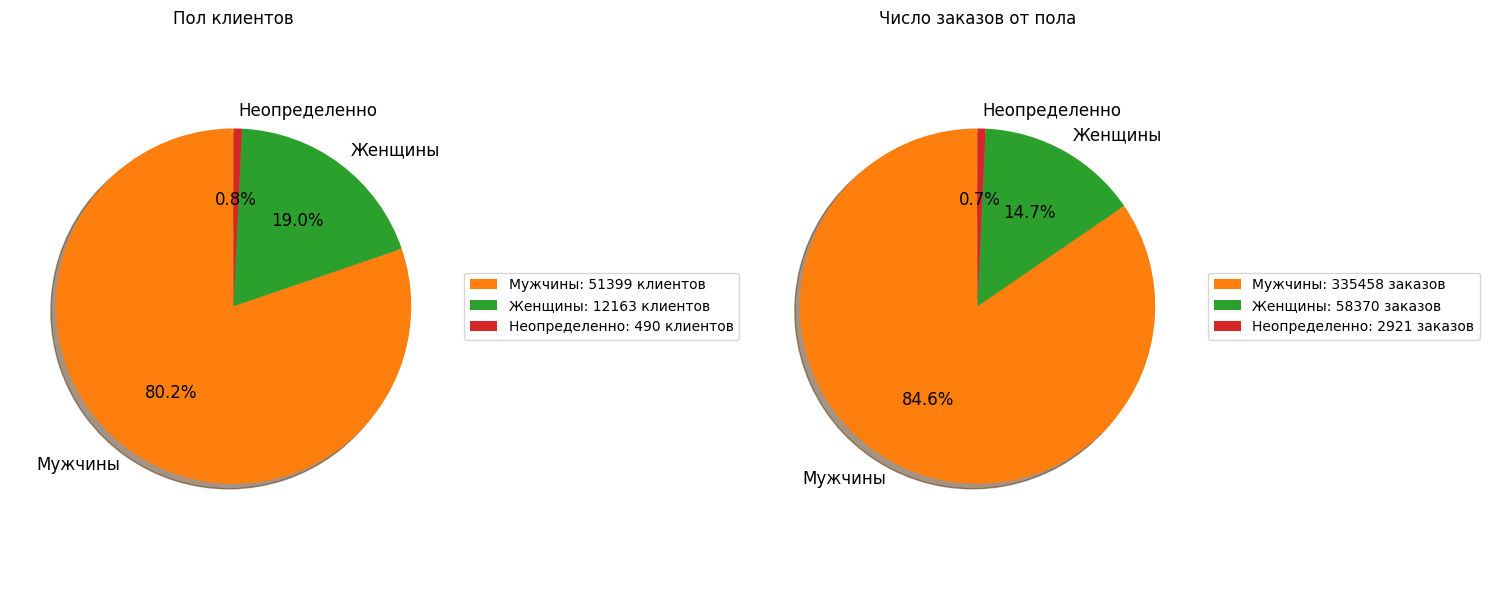

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


ax1.pie(client_gender.values,
        labels=['Мужчины', 'Женщины', 'Неопределенно'],
        autopct='%1.1f%%',
        colors=['C1', 'C2', 'C3'],
        startangle=90,
        shadow=True,
        textprops={'fontsize': 12})

legend_labels = [f'{label}: {count} клиентов' 
                for label, count in zip(['Мужчины', 'Женщины', 'Неопределенно'], client_gender.values)]
ax1.legend(legend_labels,
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1))

ax1.axis('equal')
ax1.set_title('Пол клиентов')


ax2.pie(order_gender.values,
        labels=['Мужчины', 'Женщины', 'Неопределенно'],
        autopct='%1.1f%%',
        colors=['C1', 'C2', 'C3'],
        startangle=90,
        shadow=True,
        textprops={'fontsize': 12})

legend_labels = [f'{label}: {count} заказов' 
                for label, count in zip(['Мужчины', 'Женщины', 'Неопределенно'], order_gender.values)]
ax2.legend(legend_labels,
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1))

ax2.axis('equal')
ax2.set_title('Число заказов от пола')


plt.tight_layout()
plt.show()

Среди клиентов заметно больше мужчин и они пользуются самокатами чаще

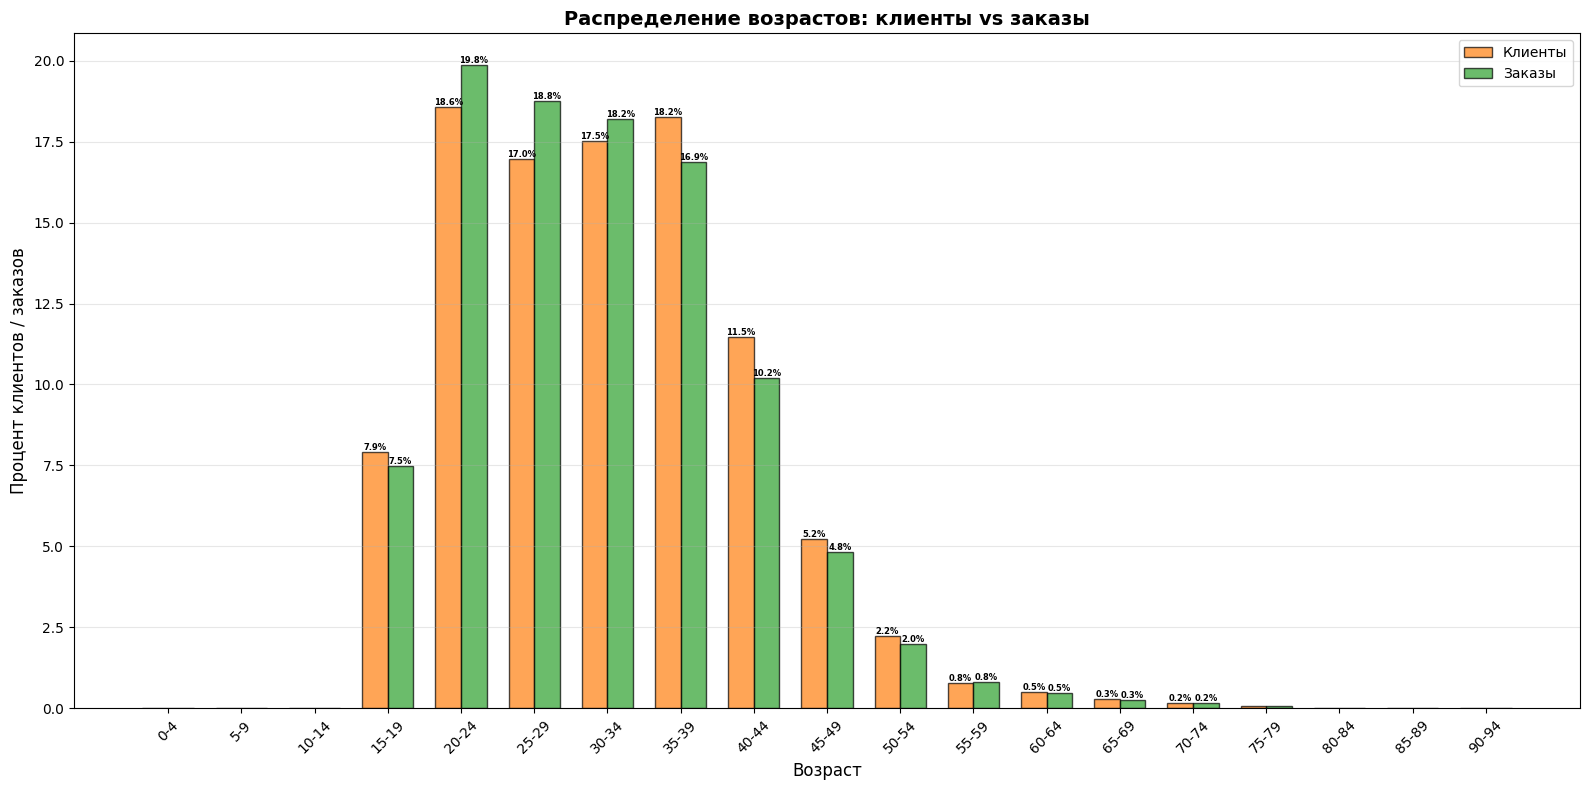

In [47]:
bin_size = 5
max_age = max(client_info['age'].max(), df['age'].max())
bins = list(range(0, int(max_age) + bin_size, bin_size))
labels = [f'{i}-{i+bin_size-1}' for i in bins[:-1]]

client_info_plot = client_info.copy()
client_info_plot['age_group'] = pd.cut(client_info_plot['age'], bins=bins, 
                                    labels=labels, right=False)
client_age_counts = client_info_plot['age_group'].value_counts().sort_index()

df_plot = df.copy()
df_plot['age_group'] = pd.cut(df_plot['age'], bins=bins, 
                                    labels=labels, right=False)
order_age_counts = df_plot['age_group'].value_counts().sort_index()

client_age_percentages = (client_age_counts / client_age_counts.sum()) * 100
order_age_percentages = (order_age_counts / order_age_counts.sum()) * 100

plt.figure(figsize=(16, 8))
x = np.arange(len(labels))
width = 0.35

bars1 = plt.bar(x - width/2, client_age_percentages.values, width, 
                label='Клиенты', color='C1', alpha=0.7, edgecolor='black')
bars2 = plt.bar(x + width/2, order_age_percentages.values, width, 
                label='Заказы', color='C2', alpha=0.7, edgecolor='black')

plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Процент клиентов / заказов', fontsize=12)
plt.title('Распределение возрастов: клиенты vs заказы', fontsize=14, fontweight='bold')
plt.xticks(x, labels, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0.1: 
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=6, fontweight='bold')


plt.tight_layout()
plt.show()


Люди старше 50 на самокатах катаются редко

Text(0.5, 1.0, 'Образование клиентов')

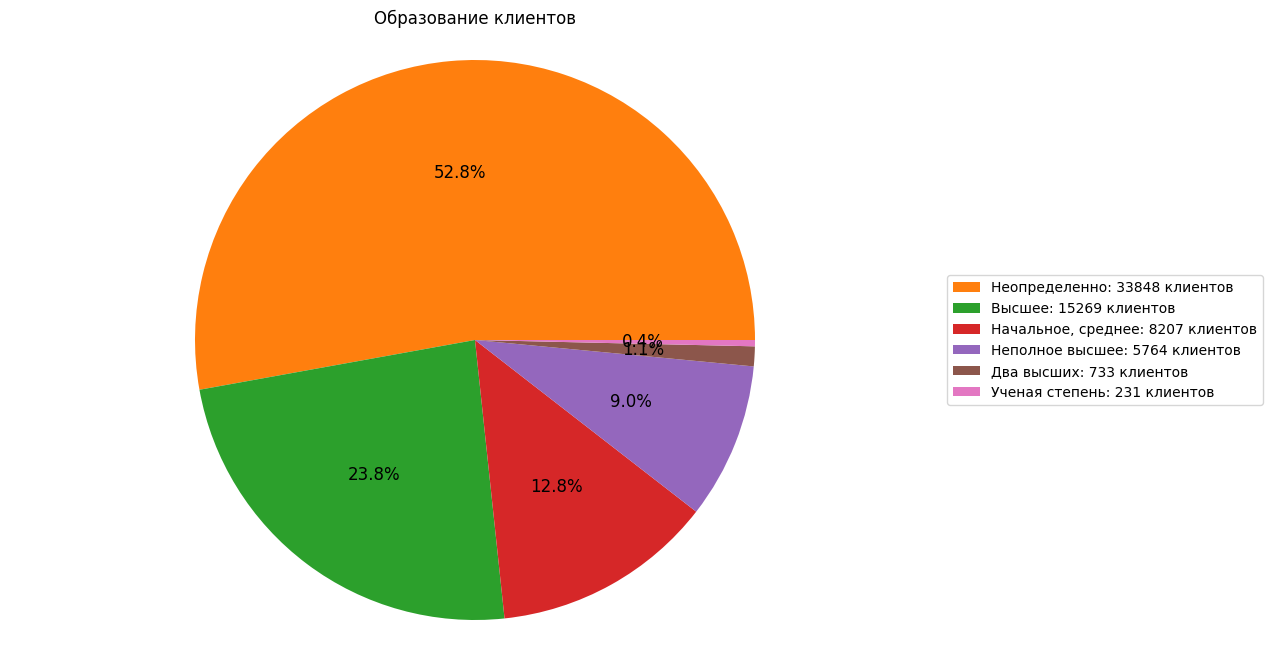

In [48]:
client_education = client_info['education_level_cd'].copy()
client_education.fillna('Missing', inplace=True)
education = client_education.value_counts()

education_map = {'SCH' : 'Начальное, среднее', 'GRD' : 'Высшее', 'UGR' : 'Неполное высшее', 'PGR' : 'Два высших', 'ACD' : 'Ученая степень', 'Missing' : 'Неопределенно'}

education_label = [education_map.get(i, str(i)) for i in education.index]

plt.figure(figsize=(12, 8))
plt.pie(education.values,
        autopct='%1.1f%%',
        colors=['C1', 'C2', 'C3', 'C4', 'C5', 'C6'],
        startangle=0,
        textprops={'fontsize': 12})

legend_labels = [f'{label}: {count} клиентов' 
                for label, count in zip(education_label, education.values)]
plt.legend(legend_labels,
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1))

plt.axis('equal')
plt.title('Образование клиентов')

In [49]:
client_status = client_info['marital_status_cd'].copy()
client_status.fillna('Missing', inplace=True)
status = client_status.value_counts()
print(status)

marital_status_cd
Missing    29581
UNM        16631
MAR        13266
CIV         2595
DIV         1850
WID          129
Name: count, dtype: int64


Text(0.5, 1.0, 'Семейный статус')

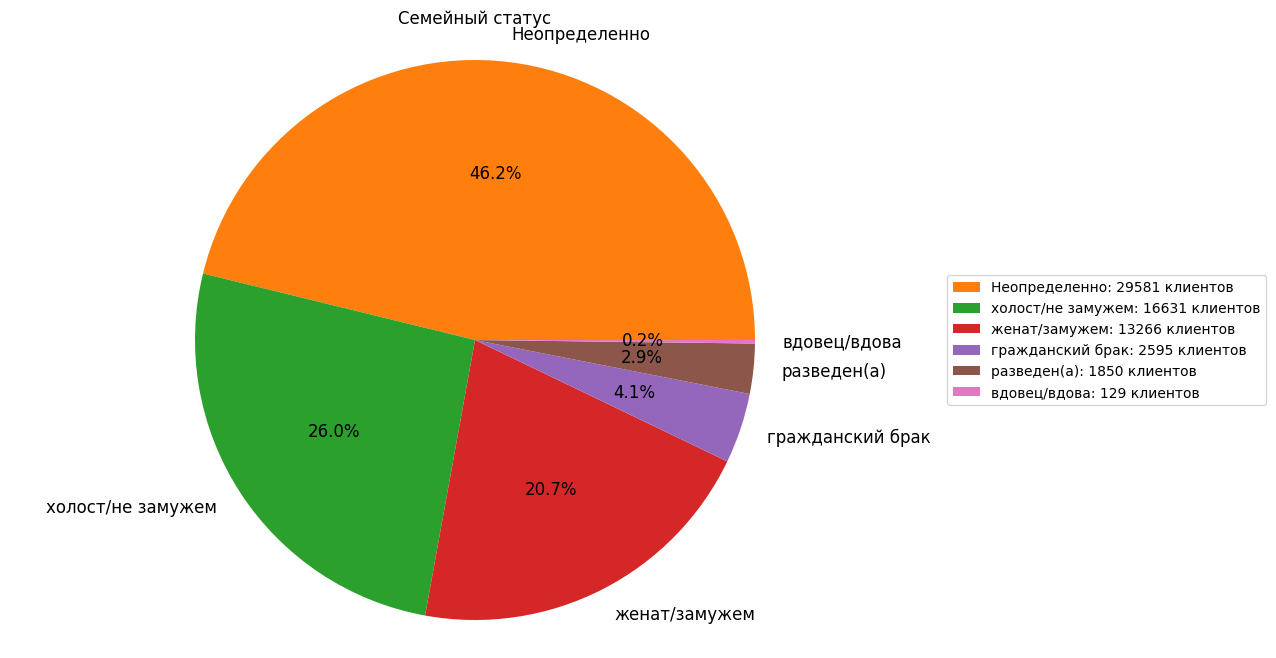

In [50]:
status_map = {'IMR' : 'состоит в незарегистрированном браке',  
'MAR' : 'женат/замужем',
'DLW' : 'не проживает с супругом(ой)',
'OMR' : 'состоит в зарегистрированном браке',
'CIV' : 'гражданский брак',
'UNM' : 'холост/не замужем', 
'DIV' : 'разведен(а)',
'FAL' : 'никогда не состоял(а) в браке',
'WID' : 'вдовец/вдова',
'Missing' : 'Неопределенно'}

status_label = [status_map.get(i, str(i)) for i in status.index]

plt.figure(figsize=(12, 8))
plt.pie(status.values,
        labels=status_label,
        autopct='%1.1f%%',
        colors=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10'],
        startangle=0,
        textprops={'fontsize': 12})

legend_labels = [f'{label}: {count} клиентов' 
                for label, count in zip(status_label, status.values)]
plt.legend(legend_labels,
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1))

plt.axis('equal')
plt.title('Семейный статус')

In [51]:
client_state = client_info['lvn_state_nm'].copy()
client_state.fillna('Missing', inplace=True)
state = client_state.value_counts()
print(state)

lvn_state_nm
Г МОСКВА                 11708
Missing                   6205
МОСКОВСКАЯ ОБЛ            6044
Г САНКТ-ПЕТЕРБУРГ         5490
СВЕРДЛОВСКАЯ ОБЛ          3275
                         ...  
Г САМАРА                     1
МОГИЛЕВСКАЯ ОБЛ              1
ОБЛАСТЬ ЛЕНИНГРАДСКАЯ        1
ОБЛАСТЬ УЛЬЯНОВСКАЯ          1
САХАЛИНСКАЯ ОБЛАСТЬ          1
Name: count, Length: 213, dtype: int64
